In [56]:
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer, DropoutLayer, DenseLayer
from lasagne.layers import Conv2DLayer, MaxPool2DLayer, Pool2DLayer
from lasagne.objectives import categorical_crossentropy, squared_error
from lasagne.updates import sgd, rmsprop

from lasagne.nonlinearities import rectify, softmax, tanh, sigmoid, linear
from lasagne.init import GlorotUniform

import numpy as np
import matplotlib.pyplot as plt

## build model

In [93]:
def build_mlp(input_var=None):
    l_in = InputLayer(shape=(None, 1, 28, 28), input_var=input_var)
    l_hid1 = DenseLayer(l_in, num_units=100, nonlinearity=rectify, W=GlorotUniform())
    l_hid2 = DenseLayer(l_hid1, num_units=10, nonlinearity=softmax, W=GlorotUniform())
    return l_hid2
    

def build_cnn(input_var=None):
    l_in = InputLayer(shape=(None, 1, 28, 28), input_var=input_var)
    
    l_conv1 = Conv2DLayer(l_in, num_filters=32, filter_size=(5, 5), nonlinearity=rectify, W=GlorotUniform(), pad='same')
    l_pool1 = Pool2DLayer(l_conv1, pool_size=(2, 2), mode='max')
    
    l_output = DenseLayer(l_pool1, num_units=10, nonlinearity=softmax, W=GlorotUniform())
    return l_output

## prepared data

In [94]:
from Teemo.examples.mnist import load_data
trn_X, trn_y, valid_X, valid_y = load_data.mnist(dim_ordering='th', one_hot=True)
trn_X /= 255.
valid_X /= 255.

print trn_X.shape, trn_y.shape

(60000, 1, 28, 28) (60000, 10)


## train model

In [132]:
from Teemo.algorithm.utils import matrixops
def train_model(model, input_var, target_var, trn_X, trn_y, valid_X, valid_y, nb_epoch=10, mini_batch=32):
    
    pred = lasagne.layers.get_output(model)
    loss = categorical_crossentropy(pred, target_var).mean()
    params = lasagne.layers.get_all_params(model, trainable=True)
    updates = sgd(loss, params, learning_rate=0.01)
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    evaluate_fn = evaluate_model(model, input_var, target_var)
    trn_loss_list = []
    valid_metrics_list = []
    for ii in range(nb_epoch):
        tmp_loss_list = []
        for mb_x, mb_y in matrixops.iterate_minibatches(mini_batch, trn_X, trn_y, shuffle=True):
            tmp_loss = train_fn(mb_x, mb_y)
            tmp_loss_list.append(tmp_loss)
        trn_loss = np.mean(tmp_loss_list)
        trn_loss_list.append(trn_loss)
        valid_metrics = evaluate_fn(valid_X, valid_y)
        valid_metrics_list.append(valid_metrics)
        print 'Training epoch: {0}, valid_metrics: {1}'.format(ii, valid_metrics)
    return valid_metrics_list


def gen_metric_fn(model, input_var, target_var):
    valid_pred = lasagne.layers.get_output(model, deterministic=True) ## deterministic will disable dropout layer
    valid_loss = categorical_crossentropy(valid_pred, target_var).mean()
    valid_acc = T.mean(T.eq(T.argmax(valid_pred, axis=1), T.argmax(target_var, axis=1)), dtype=theano.config.floatX)

    metric_fn = theano.function([input_var, target_var], [valid_loss, valid_acc])
    return metric_fn

In [133]:
input_var = T.tensor4('inputs')
target_var = T.matrix('targets')
model = build_mlp(input_var)
valid_metrics_list = train_model(model, input_var, target_var, trn_X, trn_y, valid_X, valid_y)

Training epoch: 0, valid_metrics: [array(0.3637428405258666), array(0.9018)]
Training epoch: 1, valid_metrics: [array(0.29830362755188106), array(0.9172)]
Training epoch: 2, valid_metrics: [array(0.2628807630675223), array(0.9276)]
Training epoch: 3, valid_metrics: [array(0.24310485410873317), array(0.9325)]
Training epoch: 4, valid_metrics: [array(0.2279015581149729), array(0.9361)]
Training epoch: 5, valid_metrics: [array(0.21278974040677148), array(0.9398)]
Training epoch: 6, valid_metrics: [array(0.20039607601546916), array(0.9426)]
Training epoch: 7, valid_metrics: [array(0.18985401023405082), array(0.9461)]
Training epoch: 8, valid_metrics: [array(0.17872544669128035), array(0.9484)]
Training epoch: 9, valid_metrics: [array(0.17043268103265813), array(0.9499)]


## visualization

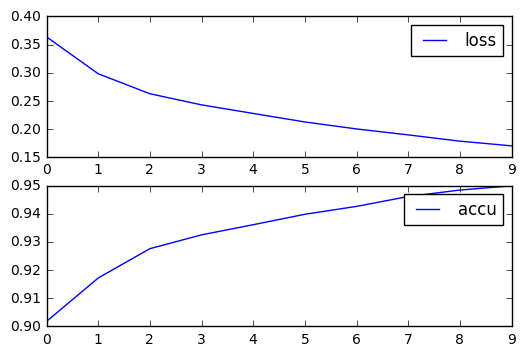

In [137]:
plt.figure()
plt.subplot(211)
plt.plot(range(len(valid_metrics_list)), [x[0] for x in valid_metrics_list], label='loss')
plt.legend()
plt.subplot(212)
plt.plot(range(len(valid_metrics_list)), [x[1] for x in valid_metrics_list], label='accu')
plt.legend()
plt.show()